<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/llamaindex/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval for Climate Change APP
Reference: [Notebook link](https://github.com/run-llama/llama_index/blob/main/docs/examples/multi_modal/multi_modal_retrieval.ipynb) from LlamaIndex & [Blog post](https://medium.com/gitconnected/multimodal-retrieval-with-text-embedding-and-clip-image-embedding-for-backyard-birds-599f19057a70) from Wenqi Glantz.



Let's build a Multi-Modal retrieval system using LlamaIndex.

1. OpenAI CLIP model `ViT-B/32` for image embeddings.
2. `embed-englishv3` for text embeddings. (cohere embedding) [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
3. `Aya Model` as LLM for text response synthesizing. (NOT AVAILABLE FOR COHERE YET USING COMMAND Model)



Steps:
1. Upload Climate PDF Files.
2. Index the text using `embed-englishv3` embeddings.
3. Index the images using OpenAI [CLIP](https://github.com/openai/CLIP) embeddings.
5. Both the text and image embeddings are stored as separate collection in [Qdrant](https://qdrant.tech/).
4. During query, retrieve both text and images.

**CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs**

In [ ]:
%%capture
!pip install llama_index ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!pip install matplotlib scikit-image
!pip install -U qdrant_client
!pip install PyPDF2 Cohere llama_index
!pip install fastapi
!pip install llama_index[schema]

## Load Multi-Modal datasets including texts and images from PDF

Parse PDF articles and save into local folder

In [ ]:
pdf_sources = {
    "Toronto Climate Action Plans": {
        "pdf_name": "TorontoClimateactionplans.pdf",
        "url": "https://www.toronto.ca/legdocs/mmis/2023/ex/bgrd/backgroundfile-237948.pdf"
    },
    "Climate Change Anxiety": {
        "pdf_name": "Climatechangeanxiety.pdf",
        "url": "https://www.thelancet.com/journals/lanplh/article/PIIS2542-5196(21)00278-3/fulltext"
    },
    "Rexdale SNAP Action Plan": {
        "pdf_name": "Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2.pdf",
        "url": "https://trca.ca/conservation/sustainable-neighbourhoods/snap-neighbourhood-projects/rexdale-snap/"
    }
}

In [ ]:
from pathlib import Path
import PyPDF2

pdf_titles = [
    "TorontoClimateactionplans.pdf",
    "Climatechangeanxiety.pdf",
    "Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2.pdf"
]

data_path = Path("data_pdfs")

if not data_path.exists():
    Path.mkdir(data_path)

for title in pdf_titles:
    with open(title, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        num_pages = len(reader.pages)

        pdf_text = ""
        for page in range(num_pages):
            pdf_text += reader.pages[page].extract_text()

        # Prepare the document metadata including the PDF source information
        pdf_info = next((info for name, info in pdf_sources.items() if info["pdf_name"] == title), None)
        pdf_metadata = {
            "pdf_name": pdf_info["pdf_name"] if pdf_info else "Unknown",
            "url": pdf_info["url"] if pdf_info else "Unknown"
        }

        # Include the PDF metadata at the beginning of the text
        pdf_text = f"PDF Name: {pdf_metadata['pdf_name']}\nPDF URL: {pdf_metadata['url']}\n\n{pdf_text}"

        # Save the document with the metadata included
        with open(data_path / f"{title[:-4]}.txt", "w") as fp:
            fp.write(pdf_text)

In [ ]:
#pwd

In [ ]:
#!rm -rf /content/data_pdfs/

In [ ]:
#!rm -rf /content/images_pdfs/

In [ ]:
import os
import cohere
from getpass import getpass
# Set up Cohere client and choose model
co_api_key = getpass("Enter Cohere API key: ")
co = cohere.Client(api_key=co_api_key)

Enter Cohere API key: ··········


## Build text index for Vector Store and define the text query engine

In [ ]:
%%capture
!pip install transformers llama-index llama-index-llms-cohere llama-index-embeddings-huggingface
!pip install llama-index-vector-stores-postgres llama-index-vector-stores-qdrant
!pip install -U qdrant_client fastembed llama-index-vector-stores-chroma
!pip install llama-index-embeddings-cohere

In [ ]:
import qdrant_client
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex, StorageContext, Settings
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.llms.cohere import Cohere
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.cohere import CohereEmbedding

# Configure the global Settings according to the documentation
Settings.llm = Cohere(model = 'command-r-plus', temperature=0.1, api_key=co_api_key)
Settings.embed_model = CohereEmbedding(cohere_api_key=co_api_key,model_name="embed-english-v3.0")
#Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

# create QdrantClient with the location set to ":memory:", which means the vector db will be stored in memory
text_client = qdrant_client.QdrantClient(location=":memory:")

# load Text documents from the data_pdfs directory
text_documents = SimpleDirectoryReader("./data_pdfs").load_data()

# Create QdrantVectorStore using QdrantClient and the collection name "climate_text"
text_vector_store = QdrantVectorStore(client=text_client, collection_name="climate_text")

# Create StorageContext object using the QdrantVectorStore
storage_context = StorageContext.from_defaults(vector_store=text_vector_store)

# Since Settings are now global, you might not need to pass service_context explicitly
# However, adjustments might be needed depending on how VectorStoreIndex interacts with Settings
climate_text_index = VectorStoreIndex.from_documents(
    text_documents,
    storage_context=storage_context
    # The service_context parameter might be omitted if Settings are automatically applied globally
)

# Define the text query engine
text_query_engine = climate_text_index.as_query_engine()

In [ ]:
len(text_documents)

3

## Build image index for vector store using OpenAI CLIP embeddings

### Load and initialize CLIP model

In [ ]:
import torch
import clip
import numpy as np

model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


### Download and store images from PDF pages

In [ ]:
## only fun if images are already loaded
#rm -rf images_pdfs

In [ ]:
from pathlib import Path
import fitz  # PyMuPDF library for extracting images from PDFs

image_path = Path("images_pdfs")
image_uuid = 0
image_metadata_dict = {}
MAX_IMAGES_PER_PDF = 40

pdf_titles = [
    "TorontoClimateactionplans.pdf",
    "Climatechangeanxiety.pdf",
    "Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2.pdf"
]

# create folder for images only if not image_path.exists():
Path.mkdir(image_path)

# Download images for PDF files
for title in pdf_titles:
    images_per_pdf = 0
    print(title)
    try:
        with fitz.open(title) as doc:
            for page_num in range(len(doc)):
                page = doc[page_num]
                images = page.get_images()
                for img in images:
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    image_uuid += 1
                    image_file_name = f"{title[:-4]}_{image_uuid}.{base_image['ext']}"
                    image_metadata_dict[image_uuid] = {
                        "filename": image_file_name,
                        "img_path": "./" + str(image_path / image_file_name),
                        "pdf_title": title,
                    }
                    with open(image_path / image_file_name, "wb") as f:
                        f.write(base_image["image"])
                    images_per_pdf += 1
                    if images_per_pdf > MAX_IMAGES_PER_PDF:
                        break
    except Exception as e:
        print(f"Error processing {title}: {str(e)}")
        continue

TorontoClimateactionplans.pdf
Climatechangeanxiety.pdf
Rexdale-SNAP-Action-Plan-Report-11-20-23-FA-2.pdf


### Show downloaded Images from pdf

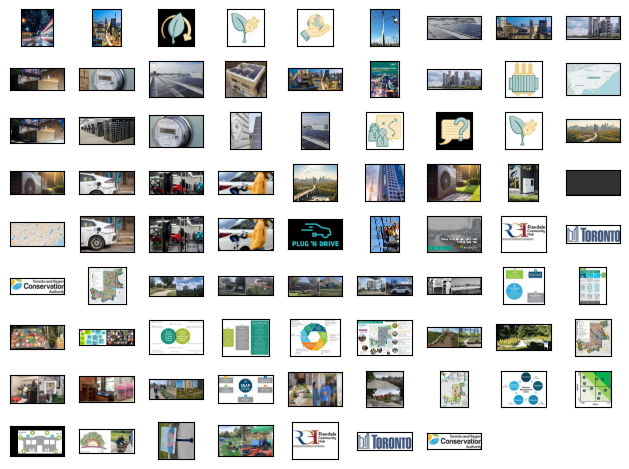

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(9, 9, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 79:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Generate Clip embedding for each each image

In [ ]:
# set the device to use for the CLIP model, either CUDA (GPU) or CPU, depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)
print(clip.available_models())

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}
with torch.no_grad():

    # iterate over the image metadata dictionary and extracts image embeddings for each image
    for image_id in image_metadata_dict:
        img_file_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 2
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )

            # extract image features using the CLIP model's encode_image function
            image_features = model.encode_image(image)

            # store the image features in the image embedding dictionary
            img_emb_dict[image_id] = image_features

cpu
['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [ ]:
len(img_emb_dict) #79 image so 79 img emb

79

In [ ]:
image_id = 1  # replace with the ID of the image you're interested in
print(image_metadata_dict[image_id])

{'filename': 'TorontoClimateactionplans_1.jpeg', 'img_path': './images_pdfs/TorontoClimateactionplans_1.jpeg', 'pdf_title': 'TorontoClimateactionplans.pdf'}


\### Build a separate CLIP image embedding index under a differnt collection `PDF_img`

In [ ]:
from llama_index.core.schema import ImageDocument

# create a list of ImageDocument objects, one for each image in the dataset
img_documents = []
for image_filename in image_metadata_dict:
    # the img_emb_dict dictionary contains the image embeddings
    if image_filename in img_emb_dict:
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]
        #print(filepath)

        # create an ImageDocument for each image
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )

        # set image embedding on the ImageDocument
        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

# create QdrantVectorStore, with collection name "pdf_img"
image_vector_store = QdrantVectorStore(
    client=text_client, collection_name="pdf_img"
)

# define storage context
storage_context = StorageContext.from_defaults(vector_store=image_vector_store)

# define image index
image_index = VectorStoreIndex.from_documents(
    img_documents,
    storage_context=storage_context
)

### Function for image query

- `retrieve_results_from_image_index` takes a text query as input and returns the most similar image from the vector store.
- `plot_image_retrieval_results` takes a list of image retrieval results and creates a new figure.
- `image_query` is a wrapper function to call the two functions above.

In [ ]:
from llama_index.core.vector_stores import VectorStoreQuery


def retrieve_results_from_image_index(query):
    """ take a text query as input and return the most similar image from the vector store """

    # first tokenize the text query and convert it to a tensor
    text = clip.tokenize(query).to(device)

    # encode the text tensor using the CLIP model to produce a query embedding
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1, # returns 1 image
        mode="default",
    )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results


In [ ]:
def plot_image_retrieve_results(image_retrieval_results):
    """ take a list of image retrieval results and create a new figure"""

    plt.figure(figsize=(16, 5))

    img_cnt = 0

    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.

    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

In [ ]:
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    plot_image_retrieve_results(image_retrieval_results)

## TEST 1 Get MultiModal retrieval results (both text and images) for some example queries

Text retrieval results: 
Portugal


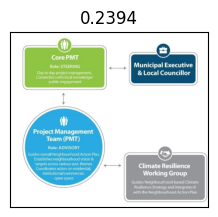

In [ ]:
# Climatechangeanxiety
query1 = "Which country is worrying the most about climate change?"
# generate image retrieval results
image_query(query1)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query1)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
The Rexdale Action Plan, also known as the Rexdale SNAP Action Plan, is a comprehensive strategy designed to revitalize and enhance the Rexdale neighborhood. It aims to address the challenges faced by the community, such as high living costs, food insecurity, lack of job opportunities, and the threat of violent crime. 

The plan outlines several key action areas, including:
1. Open Space Revitalization and Green Infrastructure: This involves enhancing and revitalizing public spaces, such as parks and community gathering areas, to make them greener, safer, and more accessible for residents.
2. Boosting the Neighborhood's Circular and Sharing Economy: The plan promotes a circular and sharing economy to address housing issues and the high cost of living. This includes programs and initiatives to encourage the sharing and reuse of resources, skills, and services within the community.
3. Retrofits for Sustainable Housing: This action area focuses on making housing m

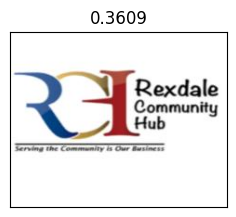

In [ ]:
# Rexdale action plans
query2 = "What is rexdale action plans?"
# generate image retrieval results
image_query(query2)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query2)
print("Text retrieval results: \n" + str(text_retrieval_results))

Text retrieval results: 
The Etobicoke Demand Response Program is an initiative by Toronto Hydro to manage peak demand and avoid costly infrastructure upgrades. The program targets two at-capacity transformer stations in Etobicoke, aiming to reduce power usage during peak periods by incentivizing customers to use their own generation and storage systems. Customers are paid to reduce their power consumption, and the utility can avoid or defer expensive upgrades. This program also prioritizes carbon-free energy sources and is expected to evolve towards more sustainable options.


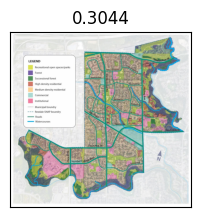

In [ ]:
# Climate action plan Hydro
query3 = "What is Etobicoke demand response program?"
# generate image retrieval results
image_query(query3)

# generate text retrieval results
text_retrieval_results = text_query_engine.query(query3)
print("Text retrieval results: \n" + str(text_retrieval_results))

## TEST 2 Refine MultiModal retrieval results (both text and images) for some example queries



Steps:
1. Add Context to the model
2. Markdown
3. Only put images that are relevant
4. Both the text and image embeddings
5. Provide Sources


In [ ]:
from llama_index.core.vector_stores import VectorStoreQuery
from IPython.display import Markdown, display

def retrieve_results_from_image_index(query):
    """ take a text query as input and return the most similar image from the vector store """

    # first tokenize the text query and convert it to a tensor
    text = clip.tokenize(query).to(device)

    # encode the text tensor using the CLIP model to produce a query embedding
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1, # returns 1 image
        mode="default",
    )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results

def plot_image_retrieve_results(image_retrieval_results):
    """ take a list of image retrieval results and create a new figure"""

    plt.figure(figsize=(16, 5))

    img_cnt = 0

    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.

    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1

def generate_response(query, text_retrieval_results, image_retrieval_results):
    response = f"##User Question\n\n {query}\n\n"
    response += f"## Answer\n\n{text_retrieval_results}\n\n"


    # Get the PDF title from the text source
    text_source = text_retrieval_results.source_nodes[0].text if hasattr(text_retrieval_results, 'source_nodes') else 'N/A'
    text_source_title = text_source.split('/')[-1] if text_source != 'N/A' else 'N/A'

    # Get the PDF title from the image source
    image_source = image_retrieval_results.nodes[0].text
    image_source_title = image_source.split('_')[0]

    # Check if the image has a high probability match to the text
    image_score = image_retrieval_results.similarities[0]
    if image_score >= 0.8:
        response += f"## Relevant Image\n\n"
        response += f"\n## Sources\n\nText source: [{text_source_title}]\n"
        response += f"Image source: [{image_source_title}]\n\n"
    else:
        response += f"\n## Sources\n\nText source: [{text_source_title}]\n"

    return response

def query_assistant(query):
    # Context to enrich the query for text retrieval purposes
    #context = "You are climate change helpful assistant to help answer questions about climate change. Your purpose is to help youth and adults understand how to deal with climate anxiety. You will refine the user questions to make it more detailed, friendly and educational. The user did not provide any data and is inquiring to learn and the information you pull from are verified Sources in which are helping you answer in full complete sentances."

    # Enriching the user's query with the context for text retrieval
    enriched_query = f"{query}"

    # Generate image retrieval results using the original user query
    image_retrieval_results = retrieve_results_from_image_index(query)

    # Generate text retrieval results using the enriched query
    text_retrieval_results = text_query_engine.query(enriched_query)

    # Generate the final response using the original user query and retrieval results
    response = generate_response(query, text_retrieval_results, image_retrieval_results)

    # Display the response up to the relevant image section
    # display(Markdown(response))
    display (Markdown(response))

    # Additional logic for displaying images if the score threshold is met
    image_score = image_retrieval_results.similarities[0]
    if image_score >= 0.3:
        # display the relevant image using image_query
        image_query(query)

In [ ]:
query = "Which country is most worried about climate change?"
query_assistant(query)

##User Question

 Which country is most worried about climate change?

## Answer

Portugal


## Sources

Text source: [planetary-health   Vol 5   December 2021  e867Many respondents reported negative emotions; feeling 
afraid, sad, anxious, angry, powerless, helpless, and 
guilty were each reported by more than 50% of respondents (table 1; appendix p 5). The emotions least often reported were optimism and indifference. Respondents also reported a range of negative beliefs, 
All countries UK Australia USA India Philippines Nigeria France Finland Portugal Brazil
Sad
Yes 6669 (66·7%) 631 641 569 735 909 615 638 536 705 690
No 3152 (31·5%) 345 332 414 256 87 362 338 442 273 303
Prefer not to say 176 (1·8%) 24 27 17 8 3 22 24 22 22 7
HelplessYes 5095 (50·9%) 546 595 462 634 636 438 511 541 327 405
No 4720 (47·2) 437 381 519 351 356 549 449 444 647 587
Prefer not to say 186 (1·9%) 18 24 19 15 8 13 39 15 26 9
AnxiousYes 6181 (61·8%) 599 650 578 640 830 660 501 493 605 625
No 3641 (36·4%) 380 324 405 339 165 331 467 486 372 372
Prefer not to say 180 (1·8%) 21 26 16 21 6 10 32 21 23 4
AfraidYes 6734 (67·3%) 615 644 542 743 897 658 667 536]


In [49]:
query = "Que son los planes de accion de Rexdale?"
query_assistant(query)

##User Question

 Que son los planes de accion de Rexdale?

## Answer

Los Planes de Acción de Rexdale son una serie de iniciativas y recomendaciones diseñadas para mejorar la comunidad de Rexdale en varias áreas. Los planes se centran en mejorar la economía compartida y circular de la comunidad, fomentar la sostenibilidad y la vivienda asequible, y mejorar la calidad de vida de los residentes.

Las recomendaciones incluyen desarrollar una estrategia a nivel de barrio para convertir a Rexdale en el primer "Barrio de Economía Compartida y Circular de Canadá", facilitando iniciativas de economía compartida en áreas como el acceso a alimentos, el intercambio de recursos y el espacio compartido.

Los planes de acción también abordan la necesidad de viviendas accesibles y sostenibles, maximizando la calidad de vida y promoviendo viviendas funcionales, asequibles y de baja emisión de carbono.

El objetivo general de los Planes de Acción de Rexdale es crear una comunidad más próspera, sostenible e inclusiva, abordando las necesidades y prioridades de los residentes locales.


## Sources

Text source: [According to the Etobicoke Historical Society, 1799 saw the first land grants in the Rexdale area. Because 
Rexdale was so far from the main city, and had very little infrastructure, it was not a very sought -after  area. Due 
to the lack of roads, it was primarily used for cultivation, which worked well as the soil was great for agriculture. 
Very little housing was established in Rexdale until post -WWII, when the demand for housing and jobs 
increased.  
Rexdale proper was established in the early 1950’s, after Rex Wesley Heslop, a local real estate developer 
purchased farmland in what is now the Rexdale area for $110,000. He quickly began building roads, sewers, 
water mains , and houses. An astute businessman, he also took the opportunity to make an important deal with 
the Etobicoke City Council. He was granted permission to establish new industry in the area at a ratio of 35% 
industrial to 65% residential , in exchange for building houses for the neighbourh ood. In 1952, Heslop sold the Rexdale SNAP Action Plan Report  
Toronto and Region Conservation Authority     |    16first 40 homes in Rexdale to a group of employees from the AV Roe Aircraft Company in Malton. Within a year, 
the area ’s first school – Elmlea Public School —was established,  followed by Rexdale Public School two years 
later. In 1956, one of the first four  plazas in Toronto was built by Heslop and his team, and was home to 
Dominion and various other retail stores. This plaza stood in the Rexdale neighbourhood for close to 50 years, 
before being demolished and replaced with what is now the Rexdale Plaza Outd oor Mall . – This includes  a large 
Walmart Supercentre, and will soon be neighbours with a new Costco .  
Towards the late 1990s and into the early 2000s, the rapid growth seen by Rexdale over the first half of the 
century led to increasingly high crime rate s, as compared with other areas of the GTA. For years, the area lacked 
funding and adequate services to accommodate the population. As a result, the area has been notorious for its 
history with gang activity, including turf wars, guns , and drugs. With this knowledge in the media spotlight, 
Rexdale has now evolved into a neighbourhood that is supported with a mple community centres, services, and 
programs all working together to serve the needs of a growing and thriving multicultural  community.  
Today, Rexdale is home to almost 55,000  residents, comprised  primarily of those from the Indian subcontinent 
and the Caribbean. Notable i nstitutions and landmarks in Rexdale today include the North Campus of Humber 
College, the BAPS Shri Swaminarayan Mandir, as well as the Woodbine Racetrack, Mall, and Fantasy Fair.  
Left: Rex Heslop (pictured on the left) next to one of his billboards advertising his houses for sale . Right:  Rexdale 
Plaza as it looked in late 1950s – this was one of Toronto’s first 4 plazas ever built, and stood for almost 50 years . 
Rexdale SNAP Action Plan Report  
Toronto and Region Conservation Authority     |    175.0 THE SNAP GOVERNANCE MODEL  
The Rexdale SNAP was initiated and developed using a highly collaborative approach to foster co -design and co -
ownership of the Action Plan among key stakeholders and the community. Driven by a cross -section of priorities, 
the SNAP governance model allows f or the identification, exploration, and implementation of shared solutions.   
The project was guided by a Project Management Team (PMT) comprised of staff from TRCA, City of Toronto 
(Environment and Energy, Toronto Water, Parks Forestry and Recreation, Transportation Services, Social 
Development, Finance and Administration, Toronto Public Health, Toronto Indigenous Affairs Office , and the 
Emergency Preparedness Office) and the Toronto Public Library  (TPL) .  
The RCH  and resident leaders also played an integral role in PMT,  given their knowledge of local issues and close 
connections with Rexdale residents , local groups , and agencies. A Climate Resilience Working Group  was also 
created to guide the development of the neighbourhood -based Climate Resilience Strategy , and to integrate it 
into the Sustainable Neighbourhood Action Plan.]


##User Question

 What is Etobicoke demand response program?

## Answer

The Etobicoke Demand Response Program is a project that aims to manage peak demand and avoid or defer costly upgrades to existing infrastructure. It targets two at-capacity transformer stations in Etobicoke, where customers are paid to reduce their power usage during peak periods. This program encourages the use of customer-owned generation and storage systems, with potential future restrictions to carbon-free sources.


## Sources

Text source: [2MWh system that’s designed to extend the life of existing utility infrastructure by managing peak demand in the area. 
Through this project, Toronto Hydro’s control centre, engineering and feld maintenance crews have gained frst-hand experience operating the battery storage system and attained better insight into how battery storage can deliver value to customers and the distribution system as a whole. This knowledge will be critical as the electricity distribution industry transforms in response to the technology and policy forces reshaping the sector, as well as customer requests for their own solar and battery connections. 
Toronto Hydro continues to investigate other 
locations where batteries can provide value to customers and the overall distribution system. 
Toronto Hydro Climate Action Plan Status Report 14  
 
  
 
 
 
 
 
 
 
 J II Ill I Ill UI 11 
■ PROJECT PROFILE 
Advanced 
Metering for EV and Solar Integration 
Toronto Hydro is upgrading to the next generation 
of demand response-ready smart meters that support improved power outage and restoration notifcations while facilitating EV and solar panel integration. 
The project involves not only replacing the meters 
themselves, but also the underlying software that is used to communicate with Toronto Hydro’s control and billing systems. Meter replacements are scheduled to begin towards the end of 2023 and, at its peak, 15,000 meters will be replaced each month. 
Once deployed, this advanced metering 
infrastructure would lay a foundation that could allow participating customers to earn money by reducing their power consumption during peak periods in a future demand response program. Under this option, Toronto Hydro’s grid and other customers would beneft from avoiding or deferring expensive grid investments. 
Toronto Hydro Climate Action Plan Status Report 15    
  
  
3. Climate Advisory 
Services: Scaling-
Up Climate Action in Toronto 
 
 
 
■ 3. Climate Advisory Services:  
Scaling-Up Climate Action in Toronto 
3.1 Purpose: Removing Barriers to Customer Climate Action 
A Memorandum of Understanding (MOU) between Toronto Hydro and the City of Toronto 
regarding climate advisory services was signed and approved in May 2023.17 In alignment 
with the City, Toronto Hydro will actively engage customers and partners to enable climate action.]


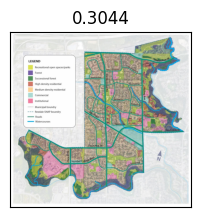

In [ ]:
query = "What is Etobicoke demand response program?"
query_assistant(query)

In [ ]:
query = "how are cars made?"
query_assistant(query)

##User Question

 how are cars made?

## Answer

Unfortunately, the provided context does not contain any information regarding how cars are made.


## Sources

Text source: [work trips under 5 km are walked,  
biked or by transit in 2030 
• 30% of registered vehicles in Toronto are electric  
by 2030 
• Install 220 Level 3 chargers and 3,000 Level 2  
chargers in public locations by 2025 
• Install 650 Level 3 chargers and 10,000 Level 2  
chargers in public locations by 2030 
• 35% of commercial vehicles in Toronto are  
electric by 2030 
Toronto Hydro Climate Action Plan Status Report 38  
 
 
 
 
 
 
 
   
 
 
   
  
  
  
 
  
 
 
■ CANADA 46 47 48 49 TORONTO50 
Oil and gas • Clean Fuel Regulations 
• Framework for oil and gas emissions  
cap released in fall 2022; draft  regulations to be published in 2023 
• At least 75% reduction in oil and gas methane emissions by 2030 relative to 2012 per framework released in Fall 2022; draft regulations to be published in 2023 
The Government of Canada will review progress under the 2030 Emissions Reduction Plan 
through progress reports produced in 2023, 2025 and 2027. Additional targets and plans will be developed for 2035 through to 2050.]
